# Lab 8
Cameron Matson

Zihao Mao

Yichen Duan

## Sentiment Analysis on Music Reviews

Our data set consists of every review from pitchfork.com since 1999, a total of 18,393 reviews of muisc albums.  Accompanied with the full lenght review, each album is rated on a scale from 0 to 10, 10 being the highest.  What we'd like to do is use a recurrent neural network to predict, from the text of the review itself, whether the reviewer gave the album a high score (7-10), a neutral score (4-7), or a low score (0-3).

One of the most common uses of sentiment analysis is to classify social media posts.  This type of information can then be used by marketing professionals as a sort of consumer survey.  This could potentially be used by music labels as well.  A music label might collect tweets, or facebook posts, or even articles on the web that mention an album that they recently released.  Then they could use our model (trained on the pitchfork reviews) to classify whether there is a consesus (or not) on how the album was recieved.

In terms of metrics, since the business case is essentially to replace human observers of the data, and we probably won't have someone observing the output at the end (because then whats the point) accuracy is probably the best metric to use when evaluating our performance.

## Data prep

The data is stored in two separate `csv` files, one that has the reviews in it, and one that has a bunch of meta data, including the score, in a different one.

In [1]:
import pandas as pd
import numpy as np

reviews = pd.read_csv('../data/reviews.csv', encoding='utf-8')
print('number of reviews:',len(reviews))
reviews.info()
reviews.head()

number of reviews: 18393
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 2 columns):
reviewid    18393 non-null int64
content     18383 non-null object
dtypes: int64(1), object(1)
memory usage: 287.5+ KB


,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


In [2]:
meta = pd.read_csv('../data/meta.csv')
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18391 non-null object
artist            18391 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [3]:
meta.drop(['title','artist', 'url', 'author', 'author_type', 'best_new_music', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year'], axis=1, inplace=True)
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 2 columns):
reviewid    18393 non-null int64
score       18393 non-null float64
dtypes: float64(1), int64(1)
memory usage: 287.5 KB


,reviewid,score
0,22703,9.3
1,22721,7.9
2,22659,7.3
3,22661,9.0
4,22725,8.1


In [4]:
df = pd.merge(reviews, meta, on='reviewid')
df.drop('reviewid', axis=1, inplace=True)
df.dropna(inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18391 entries, 0 to 18400
Data columns (total 2 columns):
content    18391 non-null object
score      18391 non-null float64
dtypes: float64(1), object(1)
memory usage: 431.0+ KB


,content,score
0,"“Trip-hop” eventually became a ’90s punchline,...",9.3
1,"Eight years, five albums, and two EPs in, the ...",7.9
2,Minneapolis’ Uranium Club seem to revel in bei...,7.3
3,Kleenex began with a crash. It transpired one ...,9.0
4,It is impossible to consider a given release b...,8.1


Finally lets group the score column so that we have a categorical target variable.  And then take a look at the distribution of the classes we set up.

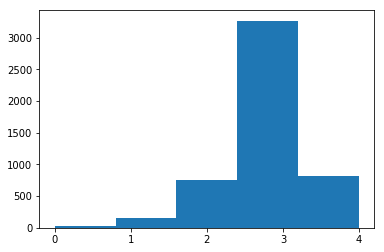

In [94]:
import matplotlib.pyplot as plt

NUM_CLASSES = 5
labels = np.arange(NUM_CLASSES)
df['target'] = pd.cut(df.score, NUM_CLASSES, labels=labels)
df.head()

plt.hist(df.target, bins=NUM_CLASSES)
plt.xticks(labels)
plt.show()

Looks like we're pretty top heavy in terms of the number of reviews for each score.  That's okay, we just need to make sure that our splits are stratified.

In [78]:
#finally lets reduce the number of articles we're working with
NUM_SAMPLES = 5000
df = df.sample(n=NUM_SAMPLES, random_state=42)

In [79]:
# this is an array of the reviews
texts = df.content.values
texts[0]

"Mantar, a new duo from Hamburg, Germany, take plenty from the groovier aspects of 90s metal, but they don't quite feel like the bands they emulate. This lies not in the riffs, but how they're presented. They don't have the street vibe of Helmet or Prong, they're not interested in a Melvinsian sense of humor, and they're not imbued with Matt Pike's stoned majesty. Moreover, they sure as hell know they're not from Louisiana. Mantar have a seriousness about them, as evidenced on their debut album Death By Burning, cloaking their sounds in a darkness that make them downright vicious. They're a band who can claim the Jesus Lizard as an influence and still hang with the rosters of staunch metalists like Iron Bonehead or Hells Headbangers.Mantar waste no time establishing their intent with lead-off cut “Spit”, going through chunky riffs that dance with a joker's mischievous, malevolent grin, and drums guided by Occam's Razor. You think it might fade out around 3:30, but not long after, guita

Now we'll use Keras's tokenizer module and pad_sequences to convert the texts into integer sequences of all the same length which makes the computation much easier and quicker

In [80]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [81]:
%%time
NUM_WORDS = 5000
MAX_ART_LEN = 1000

tkn = Tokenizer(num_words=NUM_WORDS)
tkn.fit_on_texts(texts)

sequences = tkn.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = np.asanyarray(df.target)
y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Shape of data tensor: (5000, 1000)
Shape of label tensor: (5000, 5)
4999
Wall time: 6.13 s


## RNN stuff

Okay now our data is ready to use for in the rnn.

We'll design two networks one using a LSTM cell and one using a GRU.  For each of them we'll try a few different hyper parameters first on each of them to see if we can find the best architecture.  After that we'll do a cross validation loop of five iterations on an 80/20 train/test split to evaluate the general performance

The parameters we'll investigate are dropout/recurrent_dropout (we'll move these together as one variable) and the output dimension of the RNN cell.

Both the LSTM and GRU architectures will have the same overall structure
- embedding (which will be shared between the two architectures)
- the rnn cell
- 2 dense layers (one with a hidden number of neurons and the final with the number of classes)

### Hyper parameter tuning

In [82]:
# hyper parameters
dropout_rates = [0.0, 0.2, 0.6]
latent_dims = [10, 20, 30]

In [84]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50

archs = ['LSTM', 'GRU']
rnns = []

dropout = dropout_rates[0]
latent_dim = latent_dims[0]

input_holder = Input(shape=(X_train.shape[1], ), name='in')
shared_embed = Embedding(NUM_WORDS, 
                         EMBED_SIZE, 
                         input_length=MAX_ART_LEN, name='embed')(input_holder)

            
for arch in archs:
    for dropout in dropout_rates:
        for latent_dim in latent_dims:
            func = eval(arch)
            rnn_cell = func(latent_dim, dropout=dropout, recurrent_dropout=dropout, name=arch)(shared_embed)
            hidden = Dense(20, activation='sigmoid', name='hidden')(rnn_cell)
            out = Dense(NUM_CLASSES, activation='relu', name='out')(hidden)

            rnn=Model(inputs=input_holder, outputs=out)
            rnn.compile(loss='categorical_crossentropy', 
                          optimizer='rmsprop', 
                          metrics=['accuracy'])

            print('******', arch, ':', dropout, ',', latent_dim, '********')
            print(rnn.summary())
            rnns.append((rnn, (arch, dropout, latent_dim)))


****** LSTM : 0.0 , 10 ********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 1000)              0         
_________________________________________________________________
embed (Embedding)            (None, 1000, 50)          250000    
_________________________________________________________________
LSTM (LSTM)                  (None, 10)                2440      
_________________________________________________________________
hidden (Dense)               (None, 20)                220       
_________________________________________________________________
out (Dense)                  (None, 5)                 105       
Total params: 252,765
Trainable params: 252,765
Non-trainable params: 0
_________________________________________________________________
None
****** LSTM : 0.0 , 20 ********
_________________________________________________________________
L

****** LSTM : 0.6 , 30 ********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 1000)              0         
_________________________________________________________________
embed (Embedding)            (None, 1000, 50)          250000    
_________________________________________________________________
LSTM (LSTM)                  (None, 30)                9720      
_________________________________________________________________
hidden (Dense)               (None, 20)                620       
_________________________________________________________________
out (Dense)                  (None, 5)                 105       
Total params: 260,445
Trainable params: 260,445
Non-trainable params: 0
_________________________________________________________________
None
****** GRU : 0.0 , 10 ********
_________________________________________________________________
La

****** GRU : 0.6 , 20 ********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 1000)              0         
_________________________________________________________________
embed (Embedding)            (None, 1000, 50)          250000    
_________________________________________________________________
GRU (GRU)                    (None, 20)                4260      
_________________________________________________________________
hidden (Dense)               (None, 20)                420       
_________________________________________________________________
out (Dense)                  (None, 5)                 105       
Total params: 254,785
Trainable params: 254,785
Non-trainable params: 0
_________________________________________________________________
None
****** GRU : 0.6 , 30 ********
_________________________________________________________________
Lay

In [85]:
len(rnns)

18

In [111]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.2, stratify=y_ohe)

In [ ]:
import sklearn.metrics as mt

accuracies = []

for rnn in rnns:
    print('fitting ', rnn[1])
    
    rnn[0].fit(X_train, y_train, batch_size=64, epochs=3, validation_data=[X_test, y_test])
    
    yhat = np.round(rnn[0].predict(X_test))
    acc = mt.accuracy_score(yhat, y_test)
    accuracies.append(acc, rnn[1])

fitting  ('LSTM', 0.0, 10)
Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 44s - loss: 10.8939 - acc: 0.1653 - val_loss: 11.2106 - val_acc: 0.1620
Epoch 2/3
1664/4000 [===========>..................] - ETA: 25s - loss: 11.0751 - acc: 0.1569